In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

#declare a base using 'automap_base()'
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Use `engine.execute` to select and display the first 10 rows from the station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

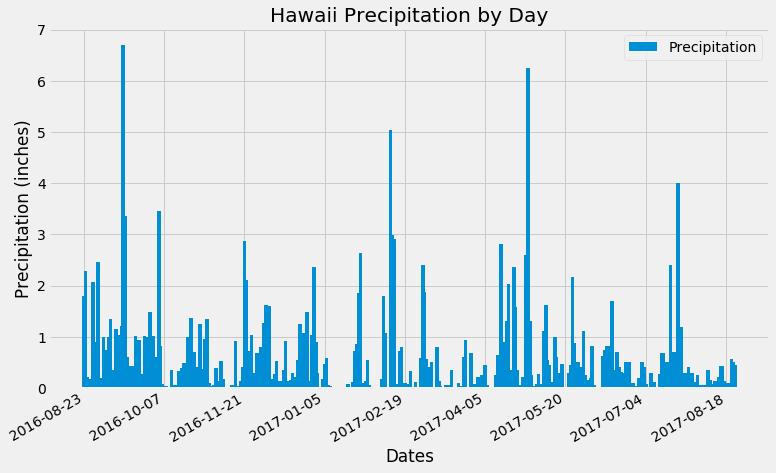

In [15]:
### Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# show results by desc and asc to determine full date range.
dates = session.query(Measurement.date).order_by(Measurement.date.asc()).all() #used .desc and .asc
dates #dates range from 1/1/2010 - 8/23/2017

# Perform a query to retrieve the date and precipitation scores

# determine year
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# query last 12 months of prec data
year_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
year_results

# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(year_results, columns = ['Date','Precipitation'])
year_df.set_index('Date', inplace=True)
year_df

# Sort the dataframe by date
sorted_year_df = year_df.sort_values('Date')
sorted_year_df

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_year_df.index.values, sorted_year_df['Precipitation'], width = 2)

fig.autofmt_xdate()

tickers = mticker.MultipleLocator(45)
ax.xaxis.set_major_locator(tickers)

ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation (inches)')
ax.set_title('Hawaii Precipitation by Day')
ax.legend(['Precipitation'])
plt.show()




In [16]:
sorted_year_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = sorted_year_df.describe()
summary_stats.round(3)

,Precipitation
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
#Query the dates and temperature observations of the most active station for the last year of data.
session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519281').all()


[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

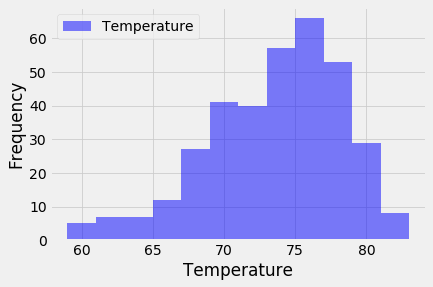

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#station with highest number of temp observations queried above: USC00519281
station_df = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago).all()

#save the query results as a Pandas DataFrame and set the index to the date column
station_temp_df = pd.DataFrame(station_df, columns = ['Date','Temperature'])

#plot histogram
station_hist = station_temp_df.plot(kind = 'hist', alpha = .5, color = 'b', bins = 12)
plt.xlabel('Temperature')
plt.grid(alpha = .8)
plt.show()



## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


## Temperature Analysis 1

In [68]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.

june_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").all()

dec_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").all()

##### T-TEST #####

june_list = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06").all()

dec_list = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "12").all()

temp_list_jun = []
for tobs in june_list:
    if type(tobs.tobs) == float:
        temp_list_jun.append(tobs.tobs)

temp_list_dec = []
for tobs in dec_list:
    if type(tobs.tobs) == float:
        temp_list_dec.append(tobs.tobs)

#stats.ttest_rel(temp_list_jun[:100],temp_list_dec[:100])
stats.ttest_ind(temp_list_jun,temp_list_dec)
        
        
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?

#ANSWER: I used an indpendent T-Test for this analysis because 1) the two sample sets (june and dec)
#are not the same or related, and 2) the two sample sets are not the same size.

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## Temperature Analysis 2

In [83]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2017,1,1)
trip_end = trip_start + dt.timedelta(days=14)

last_year_start = trip_start - dt.timedelta(days=365)
last_year_end = trip_end - dt.timedelta(days=365)

temp_results = calc_temps(last_year_start, last_year_end)

temps = list(np.ravel(temp_results))

min_temp = temps[0]
avg_temp = temps[1]
max_temp = temps[2]

trip_dict = [{"Min Temp": min_temp,"Avg Temp": avg_temp,"Max Temp": max_temp}]

trip_dict


[{'Min Temp': 62.0, 'Avg Temp': 69.875, 'Max Temp': 78.0}]

(0, 98.0)

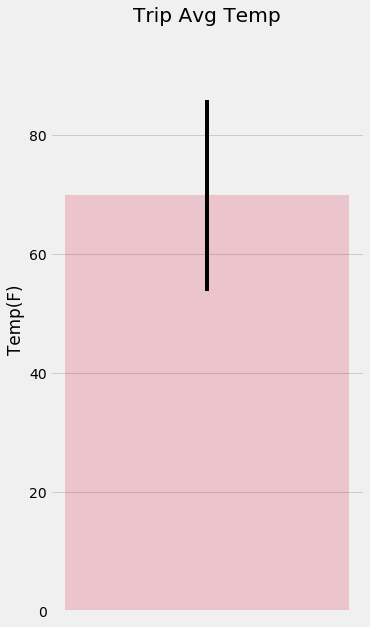

In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp1 = temps[0]
avg_temp1 = temps[1]
max_temp1 = temps[2]

x_axis = np.arange(0)

fig, ax = plt.subplots(figsize = (5,10))
ax.bar(0, avg_temp1, yerr=(max_temp1 - min_temp1), alpha = .2, color = 'crimson')
ax.set_xticks(x_axis + 1)
ax.set_title("Trip Avg Temp")
ax.set_ylabel('Temp(F)')
plt.ylim(0, max_temp1 + 20)



## Daily Rainfall Average

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude,\
        Station.longitude, Station.elevation, func.sum(Measurement.prcp),]

merged_df = session.query(*sel).filter(Measurement.station == Station.station).\
    group_by(Measurement.station).order_by((func.sum(Measurement.prcp)).desc()).all()

#create dictionary and append to list to add keys 
station_list = []
for a,b,c,d,e,f in merged_df:
    station_dict = {}
    station_dict["Station"] = a
    station_dict["Name"] = b
    station_dict["Lat"] = c
    station_dict["Long"] = d
    station_dict["Elevation"] = e
    station_dict["Total Prcp"] = f
    station_list.append(station_dict)

station_list

[{'Station': 'USC00516128',
  'Name': 'MANOA LYON ARBO 785.2, HI US',
  'Lat': 21.3331,
  'Long': -157.8025,
  'Elevation': 152.4,
  'Total Prcp': 1068.0899999999956},
 {'Station': 'USC00519281',
  'Name': 'WAIHEE 837.5, HI US',
  'Lat': 21.45167,
  'Long': -157.84888999999998,
  'Elevation': 32.9,
  'Total Prcp': 588.6399999999976},
 {'Station': 'USC00513117',
  'Name': 'KANEOHE 838.1, HI US',
  'Lat': 21.4234,
  'Long': -157.8015,
  'Elevation': 14.6,
  'Total Prcp': 382.61999999999847},
 {'Station': 'USC00519523',
  'Name': 'WAIMANALO EXPERIMENTAL FARM, HI US',
  'Lat': 21.33556,
  'Long': -157.71139,
  'Elevation': 19.5,
  'Total Prcp': 295.67999999999944},
 {'Station': 'USC00514830',
  'Name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'Lat': 21.5213,
  'Long': -157.8374,
  'Elevation': 7.0,
  'Total Prcp': 234.49000000000026},
 {'Station': 'USC00519397',
  'Name': 'WAIKIKI 717.2, HI US',
  'Lat': 21.2716,
  'Long': -157.8168,
  'Elevation': 3.0,
  'Total Prcp': 131.6200000000006

In [86]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip: trip_start and trip_end declared above
trip_start = dt.date(2017,1,1)
trip_end = trip_start + dt.timedelta(days=14)

# Use the start and end date to create a range of dates
#date_range = session.query(Measurement.date).filter(Measurement.date >= 2018-1-1).\
#    filter(Measurement.date <= trip_end).\
#    filter(func.strftime("%m-%d", Measurement.date) >= 2018-1-1).\
#    filter(func.strftime("%m-%d", Measurement.date) <= trip_end).all()
#date_range



#date range function
#pd.date_range(start,end,freq="D")   would create a df series of dates 
  
date_range = session.query(Measurement.date).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Measurement.date).all()

date_range

unraveled_dates = list(np.ravel(date_range))
unraveled_dates


#wanted_format = dt.strftime(unraveled_dates, '%Y-%m-%d').strftime("%m-%d")
#wanted_format

test = unraveled_dates.strftime("%m-%d")
test

#dates_list = [dt.datetime.strptime(date, "%Y-%m-%d").date() for date in unraveled_dates]
#dates_list

# Strip off the year and save a list of %m-%d strings
#unravel_dates = list(np.ravel(date_range))
#unravel_dates



# Loop through the list of %m-%d strings and calculate the normals for each date


AttributeError: 'list' object has no attribute 'strftime'

In [99]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip: trip_start and trip_end declared above

date_range = pd.date_range(trip_start,trip_end,freq="D") #creates a df series of dates
date_range

test = date_range.strftime("%m-%d")
test





# Loop through the list of %m-%d strings and calculate the normals for each date

Index(['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08',
       '01-09', '01-10', '01-11', '01-12', '01-13', '01-14', '01-15'],
      dtype='object')

In [88]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#df = pd.DataFrame({"Dates": date_range, "Min": min)
#new_df.set_index('Date', inplace = True)

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
#ax = new_df.plot.area(stacked=False)